In [1]:
# import all needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.callbacks import EarlyStopping

In [2]:
# <<INPUT>> stock name
stock = "BTPS.JK"

# read csv data
data = pd.read_csv(stock + ".csv", index_col=0)

# show the first five data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-08,1250.0,1460.0,1200.0,1460.0,1428.564575,74480800.0
2018-05-09,1500.0,1540.0,1460.0,1470.0,1438.349243,22920200.0
2018-05-10,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-11,1470.0,1515.0,1470.0,1510.0,1477.488037,43286000.0
2018-05-14,1510.0,1515.0,1495.0,1505.0,1472.595703,16091400.0


In [3]:
# show the last five data
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-04-09,3370.0,3390.0,3300.0,3340.0,3340.0,10569600.0
2021-04-12,3350.0,3360.0,3110.0,3110.0,3110.0,13336300.0
2021-04-13,3090.0,3170.0,2900.0,2900.0,2900.0,31969100.0
2021-04-14,2900.0,3070.0,2810.0,3070.0,3070.0,30381100.0
2021-04-15,3070.0,3150.0,3000.0,3050.0,3050.0,10874300.0


In [4]:
# we will use the Close data in the stock
procData = data.iloc[:,3]

# show the processed data length
print("Data length: {}".format(len(procData)))

Data length: 741


In [5]:
# check for null data
data.isnull().sum()

Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [6]:
is_NaN = data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = data[row_has_NaN]

print(rows_with_NaN)

            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2018-05-10   NaN   NaN  NaN    NaN        NaN     NaN
2019-06-19   NaN   NaN  NaN    NaN        NaN     NaN


In [7]:
# handling missing value with the previous value in the dataset
data.loc['2018-05-10'] = data.loc['2018-05-09']
data.loc['2019-06-19'] = data.loc['2019-06-18']
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
# <<INPUT>> test size [0 - 1]
testSize = 0.2

# show the training and test set length
train = procData[0:-math.floor(testSize*len(procData)+1)]
test = procData[-(len(procData)-len(train)):]
print("Training set length: {}    Test set length: {}".format(len(train), len(test)))

Training set length: 592    Test set length: 149


In [9]:
# <<INPUT>> look_back or how many last steps will be used in the prediction
look_back = 20

# Feature Scaling
train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min) / (train_max - train_min)
test = (test - train_min) / (train_max - train_min)
# print(len(train), len(test))
# print(*test)

In [10]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    X = np.asarray(X).astype(np.float32)
    Y = np.asarray(Y).astype(np.float32)
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(len(x_train), len(y_train), len(x_test), len(y_test))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# type(x_test)

572 572 129 129
(572, 20, 1) (572,) (129, 20, 1) (129,)


In [11]:
# BUILD the LSTM networks
# We use 1 LSTM block with 100 nodes

# Initialising the RNN-LSTM
model = Sequential()

# Adding the LSTM layer and some Dropout regularisation
model.add(LSTM(100, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(1))

# Compiling the RNN-LSTM
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the RNN to the Training set
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Show the model summary
model.summary()

Epoch 1/20
18/18 [==============================] - 1s 78ms/step - loss: 0.0319 - val_loss: 0.0457
Epoch 2/20
18/18 [==============================] - 0s 15ms/step - loss: 0.0331 - val_loss: 0.0354
Epoch 3/20
18/18 [==============================] - 0s 13ms/step - loss: 0.0244 - val_loss: 0.0340
Epoch 4/20
18/18 [==============================] - 0s 12ms/step - loss: 0.0189 - val_loss: 0.0267
Epoch 5/20
18/18 [==============================] - 0s 12ms/step - loss: 0.0173 - val_loss: 0.0251
Epoch 6/20
18/18 [==============================] - 0s 13ms/step - loss: 0.0162 - val_loss: 0.0218
Epoch 7/20
18/18 [==============================] - 0s 12ms/step - loss: 0.0153 - val_loss: 0.0208
Epoch 8/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0189
Epoch 9/20
18/18 [==============================] - 0s 18ms/step - loss: 0.0139 - val_loss: 0.0181
Epoch 10/20
18/18 [==============================] - 0s 19ms/step - loss: 0.0136 - val_loss: 0.0170
Epoch 11/

In [12]:
# train and test prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert the prediction results
train_predict = train_predict * (train_max - train_min) + train_min
y_train = y_train * (train_max - train_min) + train_min
test_predict = test_predict * (train_max - train_min) + train_min
y_test = y_test * (train_max - train_min) + train_min

# print(*test_predict)
# print()
# print(*y_test)

In [13]:
# MAPE function definition
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# check for the MAE, RMSE, and MAPE values
print('Train Mean Absolute Error (MAE):', mean_absolute_error(y_train, train_predict[:,0]))
print('Train Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_train, train_predict[:,0])))
print('Train Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_train, train_predict[:,0]))
print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_test, test_predict[:,0]))
print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, test_predict[:,0])))
print('Test Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(y_test, test_predict[:,0]))

Train Mean Absolute Error (MAE): 632.18427
Train Root Mean Squared Error (RMSE): 782.53546
Train Mean Absolute Percentage Error (MAPE): 0.21451278
Test Mean Absolute Error (MAE): 1056.9496
Test Root Mean Squared Error (RMSE): 1105.182
Test Mean Absolute Percentage Error (MAPE): 0.27587163


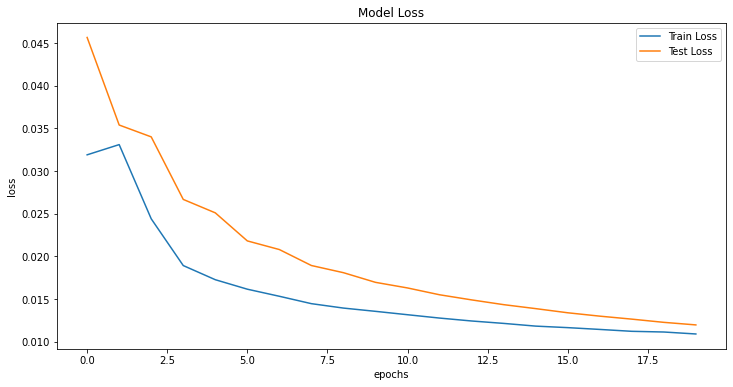

In [14]:
# Plot the model loss
fig = plt.figure(figsize=(12,6))

fig.add_subplot(111)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.show();

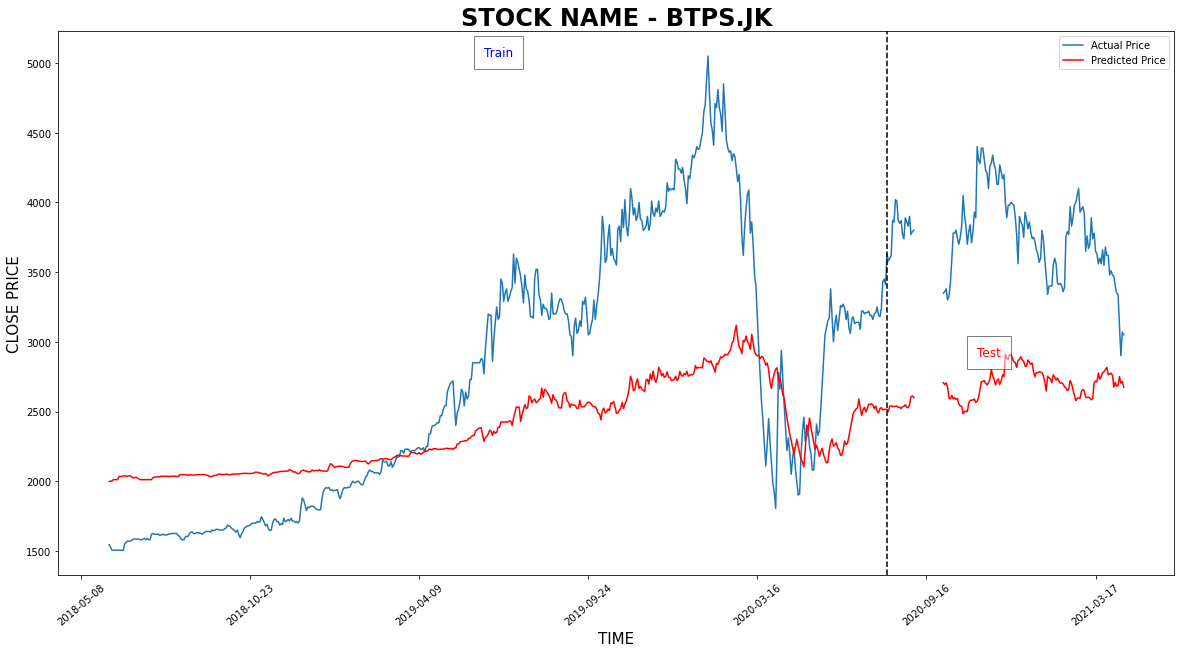

In [15]:
lb = look_back
x = data.index.values

# prepare empty array with 'lb' size
emp = np.empty(lb, dtype='object')

# combine the Train-Test results
allData = np.concatenate((emp, y_train, emp, y_test))
allPred = np.concatenate((emp, train_predict[:,0].reshape(train_predict.shape[0],),
                          emp, test_predict[:,0].reshape(test_predict.shape[0],)))

# plot the actual and prediction results
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(111)
ax.plot(x, allData, label="Actual Price")
ax.plot(x, allPred, 'r', label="Predicted Price")

# xticks and legends
ind = [i for i in range(0, len(x), 120)]
date = [x[i] for i in ind]
ax.set_xticks(ind)
ax.set_xticklabels(date, rotation=40)
ax.legend()

# title
ax.set_title("STOCK NAME - " + stock, fontsize=24, fontweight='bold')

# axis title
ax.set_xlabel('TIME', fontsize=15)
ax.set_ylabel('CLOSE PRICE', fontsize=15)

# Train-Test regions text
xTrain = int(len(y_train)/2)
yTrain = int(max(y_train))
xTest = len(y_train) + int(len(y_test)/2)
yTest = int(min(y_test))
ax.text(xTrain, yTrain, 'Train', fontsize=12, color='blue', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
ax.text(xTest, yTest, 'Test', fontsize=12, color='red', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
plt.axvline(x=len(y_train), color='k', linestyle='--')




# # divide the x axis values for Train and Test phases
# x1 = x[lb:lb + len(y_train)]
# x2 = x[2 * lb + len(y_train): 2 * lb + len(y_train) + len(y_test)]

# # plot the graph
# fig = plt.figure(figsize=(15,8))
# # make two subplots
# ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=3)
# ax2 = plt.subplot2grid((1, 5), (0, 3), colspan=2)

# # First subplot for TRAIN SET
# ax1.plot(x1, y_train, 'g', label="train actual")
# ax1.plot(x1, train_predict[:,0], 'r', label="train predict")
# # title and axis titles
# ax1.set_title("Train Phase", fontsize=18, fontweight='bold')
# ax1.set_xlabel('Time', fontsize=15)
# ax1.set_ylabel('CLOSE', fontsize=15)
# # xticks and legends
# ind = [i for i in range(0, len(x1), 120)]
# date = [x1[i] for i in ind]
# ax1.set_xticks(ind)
# ax1.set_xticklabels(date, rotation=40)
# ax1.legend()

# # Second subplot for TEST SET
# ax2.plot(x2, y_test, 'g', label="test actual")
# ax2.plot(x2, test_predict[:,0], 'r', label="test predict")
# # title and axis titles
# ax2.set_title("Test Phase", fontsize=18, fontweight='bold')
# ax2.set_xlabel('Time', fontsize=15)
# ax2.yaxis.tick_right()
# # xticks and legends
# ind = [i for i in range(0, len(x2), 60)]
# date = [x2[i] for i in ind]
# ax2.set_xticks(ind)
# ax2.set_xticklabels(date, rotation=40)
# ax2.legend()

# fig.suptitle(stock, fontsize=24, fontweight='bold')

In [16]:
from sklearn.metrics import r2_score

print('Test Accuracy:', r2_score(y_test, test_predict[:,0]))

Test Accuracy: -12.019667215088583
